# Voltage pulse design with CSP: 3 dots

This tutorial tests the voltage pulse design for the 1-qubit rotations, exchange gates, and Control-phases on a 3-qubit system. 

See 2-qubit tutorial for more detailed explanations. 

Necessary imports and default plotting parameters:

In [1]:
import os
from pathlib import Path
path = Path(os.getcwd())

# update base working directory to QuDiPy
if path.stem != 'QuDiPy':
    base_dir = path.parents[1]
    os.chdir(base_dir)
else:
    base_dir = path

In [2]:
import numpy as np
from matplotlib import pyplot as plt

from qudipy.system import State, DotArray
from qudipy.design import voltage_csp, shapes

## 1. Specifying parameters common for all control pulses

Defining nextnano/processed data directories and relevant DotArray variables.

In [3]:
nav_dir = os.path.join('QuDiPy data', 'tutorials')
processed_dir = os.path.join(base_dir, nav_dir,
                            'processed','3QD_processed')
nextnano_dir = os.path.join(base_dir, nav_dir,
                                    'nextnano','3QD')
file_prefix = 'tutorial'
n_dots = 3      # anticipated number of dots

If desired, define a subset of voltage ranges from the simulated nextnano data
set to calculate relevant effective parameters or load previously calculated 
interpolation objects.

In [4]:
pts = [4,3,4,3,4]
ctrl_vals = [
    np.linspace(0.2, 0.35, pts[0]),
    np.linspace(0.0, 0.15, pts[1]),
    np.linspace(0.2, 0.35, pts[2]),
    np.linspace(0.0, 0.15, pts[3]),
    np.linspace(0.2, 0.35, pts[4]),
]

Creating DotArray object

In [5]:
dots = DotArray(n_dots, ctrl_ranges=ctrl_vals)
dots.numeric(processed_dir, nextnano_dir, file_prefix)

Loading pre-calculated spin interpolators from
/home/zach/Documents/github/QuDiPy/QuDiPy data/tutorials/processed/3QD_processed/tutorial_spin_data_size_[4 3 4 3 4]_from_[0.2 0.  0.2 0.  0.2]_to_[0.35 0.15 0.35 0.15 0.35].pkl


Giving voltage parameters shorter names for convenient plotting

In [6]:
dots.ctrl_names = ['$V_1$', '$W_1$','$V_2$','$W_2$','$V_3$']

Choosing shape functions

In [7]:
unit_square = shapes.square()
unit_triangle = shapes.triangle()
unit_wide_gauss = shapes.gaussian(sigma=0.25)
unit_narrow_gauss = shapes.gaussian(sigma=0.15)

list_shapes = [unit_square, unit_triangle, unit_narrow_gauss, unit_wide_gauss]

Guess of idling voltage configuration

In [8]:
v_idle_guess = [0.253, 0.02, 0.27, 0.015, 0.27]

## 2. Addressing individual spins in the global ESR field

Realizing the following operation:
$$  
     \left[Y_1\left(\frac{\pi}{8}\right)\right]^4 |\uparrow - +\rangle 
          = Y_1\left(\frac{\pi}{2}\right) |\uparrow - +\rangle 
               = |+ - +\rangle
$$

Defining Designer object for a $Y\left(-\frac{3\pi}{8}\right)$ rotation:

In [9]:
B_zeeman =1

rot_des = voltage_csp.rot(dot_array=dots, active_qubits= 1, axis = 'Y', angle =  np.pi/8, 
                            min_length=10e-6, init_detuning_guess=v_idle_guess, 
                                   B_zeeman =B_zeeman,
                                          exchange_method='HM', S_max=4,
                                                 rel_diff_step=1e-7)

Initial detuning is found to be  [0.26242812 0.01975735 0.26824796 0.01559073 0.26212276]
Start solving system of ODEs
Solution FOUND!


>  Composing 4 pulses using the same designer for varied shapes and same pulse length $T=17$ ms

In [10]:
train_pulses = [rot_des.compose(num_steps=1600, length=12e-6, shape=sh) 
                                                        for sh in list_shapes]

Plotting last of the 4 pulses:

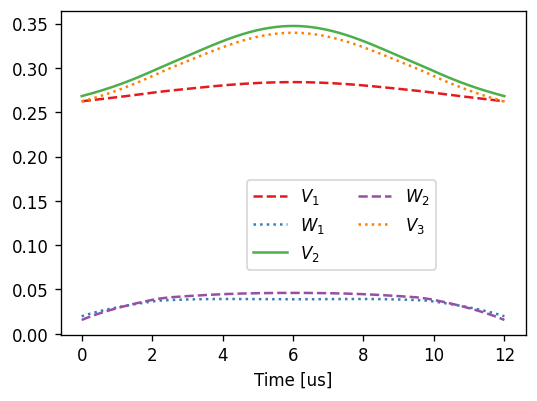

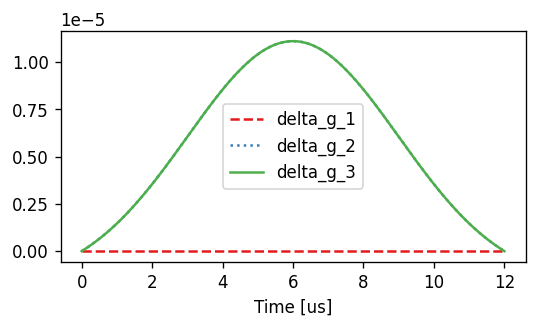

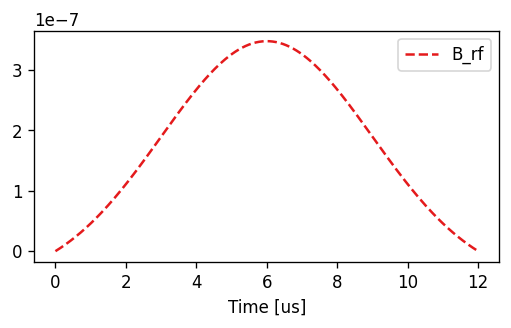

In [11]:
train_pulses[-1].plot(plot_ctrls=dots.ctrl_names, figsize= (5,3.5), loc=(0.4,0.2))
train_pulses[-1].plot(plot_ctrls=['delta_g_1', 'delta_g_2', 'delta_g_3'], ncol=1)
train_pulses[-1].plot(plot_ctrls=['B_rf'])

Defining initial and expected spin states

In [12]:
psi_up =  np.array([1,0])                           # pure spin up state
psi_down =  np.array([0,1])                         # pure spin down state
psi_plus = 1/np.sqrt(2) * np.array([1,1])           # pure |+> state
psi_minus =  1/np.sqrt(2) * np.array([1,-1])        # pure |-> state

In [13]:
init_rot = State([psi_up, psi_minus, psi_plus])
exp_rot = State([psi_plus,  psi_minus, psi_plus])

Evolving the spin system under this sequence of pulses

In [14]:
rot_data = init_rot.evolve(train_pulses, rho_reference= exp_rot.rho_spin,
                           track_qubits=(1,2), eval_fidelity=True,
                                    eval_Bloch_vectors=True)

ROTY22.50° 1, step 1600: 100%|██████████| 1600/1600 [00:03<00:00, 462.43it/s]


Plotting evolution results

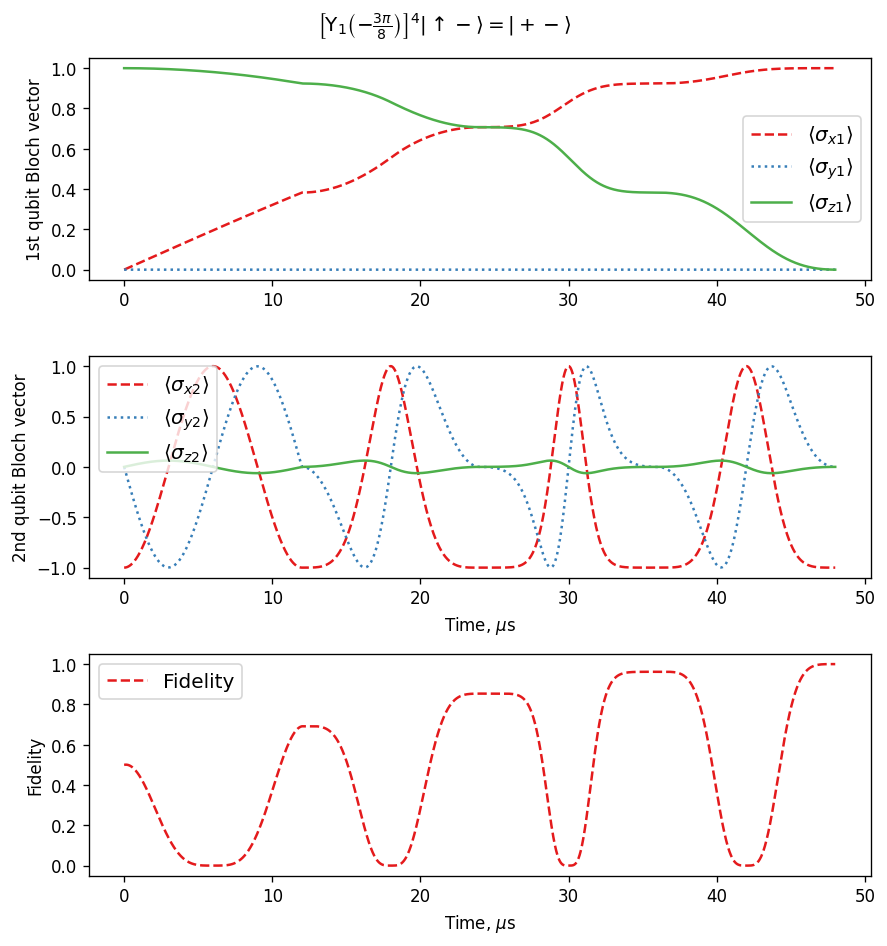

In [15]:
%matplotlib inline

fig, ax = plt.subplots(3,1, dpi=120, figsize=(7.5,8) )


ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend( fontsize="large")

###############################

ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(rot_data["time"] * 1e6, 
         np.real(rot_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, $\mu$s")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend( fontsize="large")

############

ax[2].plot(rot_data["time"] * 1e6, 
         np.real(rot_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, $\mu$s")
ax[2].set_ylabel("Fidelity")

ax[2].legend(fontsize="large")

fig.suptitle('$\\left[\\mathrm{Y}_{1}\\left(-\\frac{3\\pi}{8}\\right)\\right]^4$'
             '$ |\\uparrow -\\rangle = |+ -\\rangle$')
plt.tight_layout()
plt.show()

Note the $2\pi$ rotations around skewed axes that non-resonant qubit #3 goes through to preserve 
its initial states after each pulse.

Infidelity at the end:

In [16]:
1-rot_data['fidelity'][-1]

-1.2117448378035078e-08

## 3. $\mathrm{SWAP}^k$ two-qubit gates

This and the following sections show how to quickly run everything altogether: state definition, pulse design, and state evolution.

Testing the operation $\mathrm{SWAP}_{12} |+ \uparrow -\rangle = |\uparrow + -\rangle$ with 
four $\mathrm{SWAP}^{1/4}$ pulses of different lengths.


> DesignerEffective objects for $\mathrm{SWAP}^{1/4}$ pulses

In [17]:
swap_des = voltage_csp.swapk(dot_array=dots, qubit_pairs= (1,2), 
                          min_length=8e-9,
                                 init_detuning_guess=v_idle_guess, 
                                 B_zeeman =  B_zeeman,
                                 k=1/4,
                                 exchange_method='HM',
                                 rel_diff_step=1e-7)

Initial detuning is found to be  [0.26242812 0.01975735 0.26824796 0.01559073 0.26212276]
Start solving system of ODEs
Solution FOUND!


> Composing pulses with **different lengths** $T = 10, 20, 50, 100$ ns 
> and same shape (gaussian with $\sigma=0.2$)

In [18]:
train_swap_pulses = [swap_des.compose(num_steps = 5600, shape='gaussian', sigma=0.15, length=T) 
                            for T in 8* np.array([1e-9, 2e-9, 5e-9, 1e-8])]

Plotting all four voltage pulses

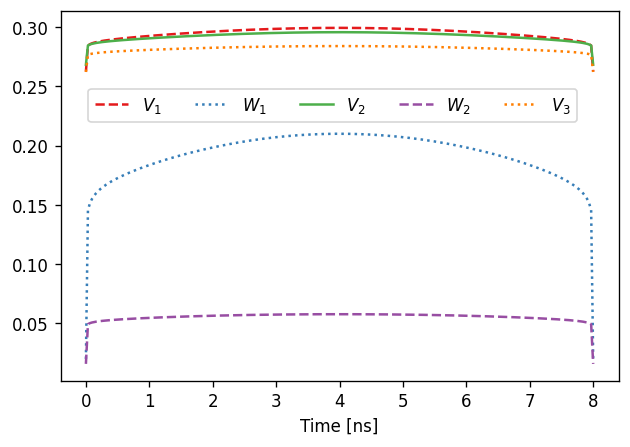

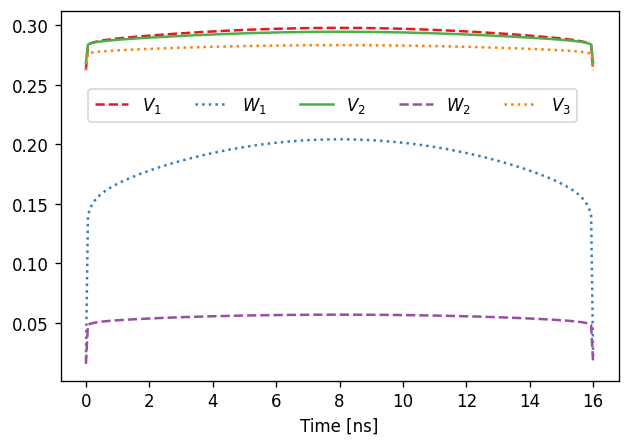

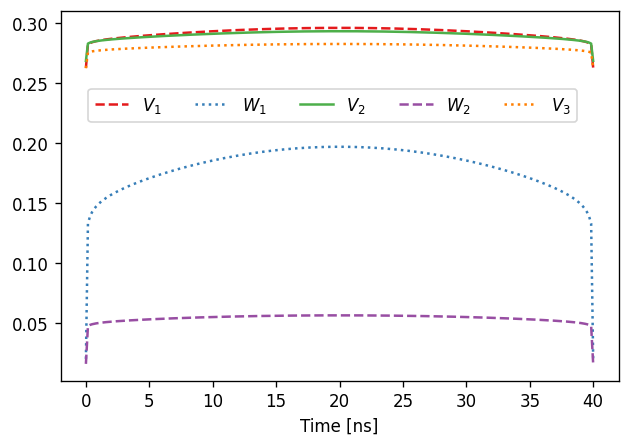

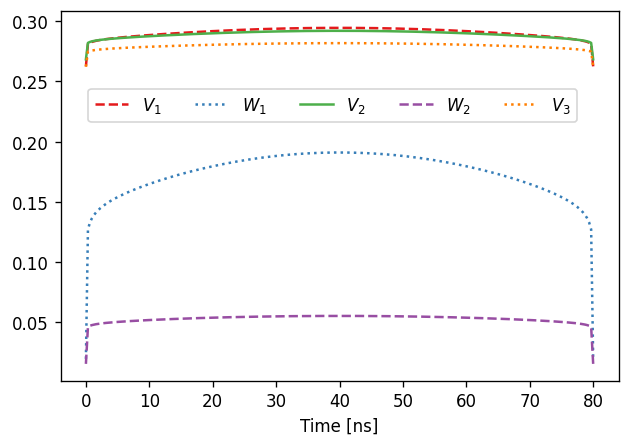

In [19]:
[pulse.plot(plot_ctrls=swap_des.dot_array.ctrl_names, figsize=(6,4), ncol=5, 
                    loc=(0.05,0.7)) for pulse in train_swap_pulses];

> Initial and expected states:

In [20]:
init_swap = State(spin=[psi_plus, psi_up, psi_minus])
exp_swap = State(spin=[psi_up, psi_plus, psi_minus])

> Evolving qubit state, plotting fidelity and Bloch vectors

In [21]:
swap_data = init_swap.evolve(train_swap_pulses, rho_reference=exp_swap.rho_spin, 
                            eval_fidelity=True, track_qubits=(1,2,3),
                                    eval_Bloch_vectors=True)

SWAP^0.25 (1, 2), step 5600: 100%|██████████| 5600/5600 [00:09<00:00, 612.22it/s]


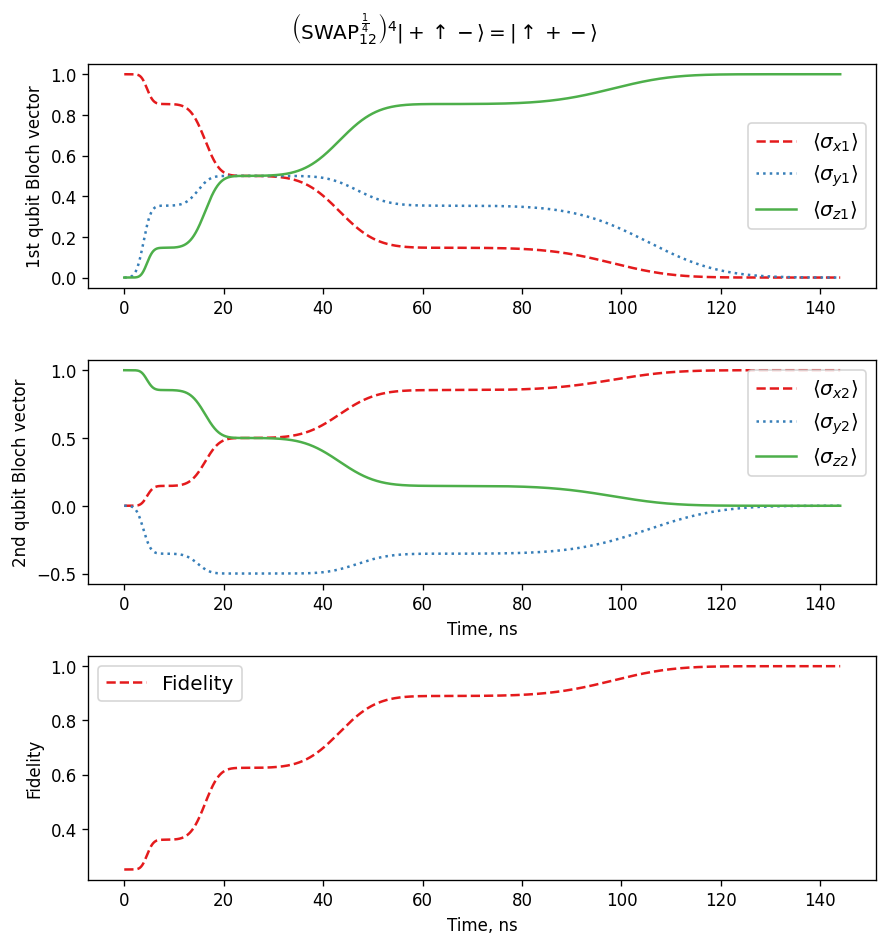

In [22]:
fig, ax = plt.subplots(3,1, dpi=120, figsize=(7.5,8) )


ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend( fontsize="large")

###############################

ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(swap_data["time"] * 1e9, 
         np.real(swap_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, ns")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend(fontsize="large")

############

ax[2].plot(swap_data["time"] * 1e9, 
         np.real(swap_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, ns")
ax[2].set_ylabel("Fidelity")

ax[2].legend(fontsize="large")

fig.suptitle('$\\left(\\mathrm{SWAP}^{\\, \\frac{1}{4}}_{12}\\right)^4 \
             |+ \\uparrow -\\rangle = |\\uparrow + -\\rangle$')
plt.tight_layout()
plt.show()

Infidelity at the end:

In [23]:
1- swap_data['fidelity'][-1]

-1.2749457489746874e-08

## 4. $\mathrm{CPHASE}(\alpha)$ two-qubit gates


Running a control-Z operation on two of three qubits:

 $$\mathrm{CZ}_{12} | + \downarrow  - \rangle = | - \downarrow -\rangle$$ 

We represent each gate control-Z gate as a combination of two control-phase gates:
$$
    \mathrm{CZ} = \mathrm{CPHASE}(\pi) = \mathrm{CPHASE}(\pi/3) \mathrm{CPHASE}(2\pi/3)
$$

> Initial and expected states:

In [24]:
init_cz = State(spin=[ psi_plus, psi_down, psi_minus])
exp_cz = State(spin=[ psi_minus, psi_down, psi_minus])

> Two DesignerEffective objects for $\mathrm{CPHASE}$ pulses. 
> Specifying all parameters, including shapes and times, right away this time

In [25]:
cphase_pi3_des = voltage_csp.cphase(dots, [(1,2)], angle = np.pi/3,
                                  init_detuning_guess =v_idle_guess, 
                                 B_zeeman =  B_zeeman, 
                                 rel_diff_step=1e-7,
                                  min_length = 2e-5)
                                  

Initial detuning is found to be  [0.26242812 0.01975735 0.26824796 0.01559073 0.26212276]
Start solving system of ODEs
Solution FOUND!


In [26]:
cphase_2pi3_des = voltage_csp.cphase(dots, [(1,2)], angle = 2* np.pi/3, 
                                  init_detuning_guess = v_idle_guess,   
                                  B_zeeman = B_zeeman,
                                 rel_diff_step=1e-7,
                                        min_length = 9e-6)

Initial detuning is found to be  [0.26242812 0.01975735 0.26824796 0.01559073 0.26212276]
Start solving system of ODEs
Solution FOUND!


> Composing corresponding pulses 

In [27]:
cphase_pulses = [cphase_pi3_des.compose(num_steps = 1600, shape='gaussian', 
                                                length = 1.75e-5, sigma=0.2), 
                        cphase_2pi3_des.compose(num_steps = 1600, 
                                    length =  1e-5, shape='triangle')]

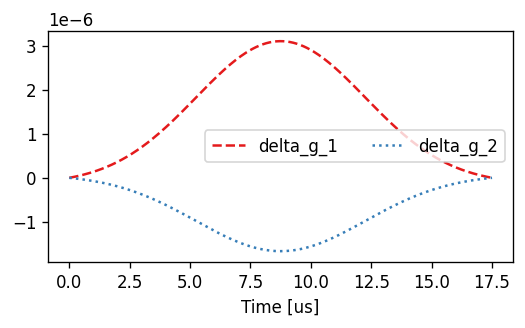

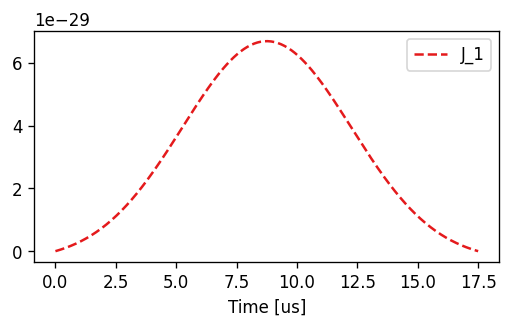

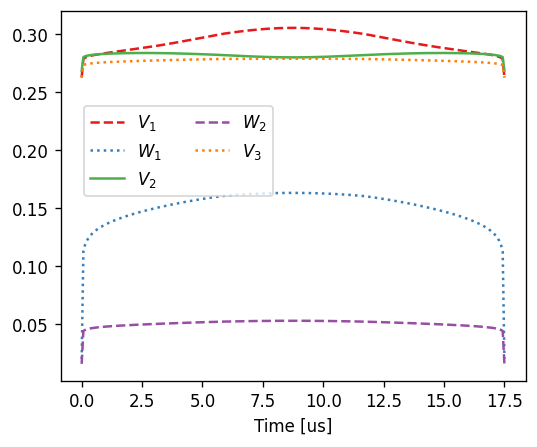

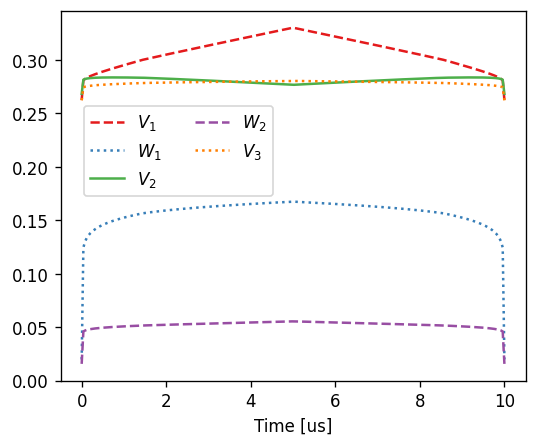

In [28]:
#plotting first pulse
cphase_pulses[0].plot(plot_ctrls=['delta_g_1', 'delta_g_2'])
cphase_pulses[0].plot(plot_ctrls=['J_1'])
cphase_pulses[0].plot(plot_ctrls=dots.ctrl_names, figsize=(5,4), loc=(0.05,0.5))
cphase_pulses[1].plot(plot_ctrls=dots.ctrl_names, figsize=(5,4), loc=(0.05,0.5))

> Evolving qubit state, plotting fidelity and Bloch vectors

In [29]:
cphase_data = init_cz.evolve(cphase_pulses, rho_reference=exp_cz.rho_spin, 
                            eval_fidelity=True, track_qubits=(1,2), 
                                    eval_Bloch_vectors=True)

CPHASE(120.00°) (1, 2), step 1600: 100%|██████████| 1600/1600 [00:03<00:00, 411.92it/s]


Plotting Bloch vector evolution of the qubits 1,2,3

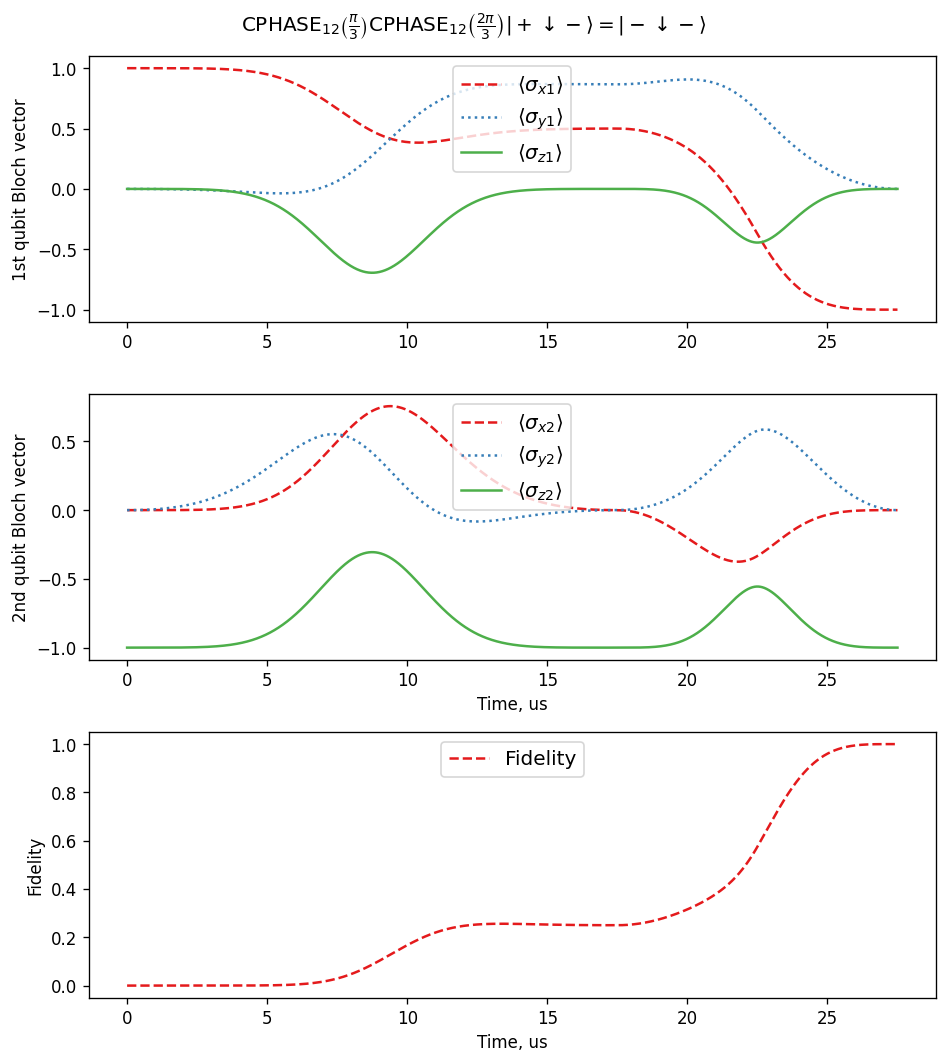

In [30]:
fig, ax = plt.subplots(3,1, dpi=120, figsize=(8,9) )

ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend(loc='upper center',  fontsize="large")

###############################

ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, us")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend(loc='upper center', fontsize="large")


ax[2].plot(cphase_data["time"] * 1e6, 
         np.real(cphase_data['fidelity']), label="Fidelity")
ax[2].set_xlabel("Time, us")
ax[2].set_ylabel("Fidelity")

ax[2].legend(loc='upper center', fontsize="large")

fig.suptitle('$\\mathrm{CPHASE}_{12}\\left(\\frac{\\pi}{3}\\right)$'
             '$ \\mathrm{CPHASE}_{12}\\left(\\frac{2\\pi}{3}\\right) $'
             '$| + \\downarrow - \\rangle = |- \\downarrow- \\rangle$')

plt.tight_layout()
plt.show()

Inidelity at the end:

In [31]:
1-cphase_data['fidelity'][-1]

-1.9609950996368752e-08

## 5. Hadamard

In [32]:
init_had = State(spin=[ psi_plus, psi_down, psi_down])
exp_had = State(spin=[ psi_up, psi_down, psi_down])

In [33]:
rot_had = voltage_csp.rot(dot_array=dots, active_qubits= 1, axis = [1,0,1], angle =  np.pi, 
                            min_length=10e-6, init_detuning_guess=v_idle_guess, 
                                   B_zeeman =B_zeeman,
                                                 rel_diff_step=1e-7)

Initial detuning is found to be  [0.26242812 0.01975735 0.26824796 0.01559073 0.26212276]
Start solving system of ODEs


In [ ]:
hadamard_pulses = [rot_had.compose(num_steps = 1600, shape='gaussian', 
                                                length = 1.75e-5, sigma=0.2)]

In [ ]:
#plotting first pulse
# cphase_pulses[0].plot(plot_ctrls=['delta_g_1', 'delta_g_2'])
# cphase_pulses[0].plot(plot_ctrls=['J_1'])
hadamard_pulses[0].plot(plot_ctrls=dots.ctrl_names, figsize=(5,4), loc=(0.05,0.5))
# hadamard_pulses[1].plot(plot_ctrls=dots.ctrl_names, figsize=(5,4), loc=(0.05,0.5))

In [ ]:
hadamard_data = init_had.evolve(hadamard_pulses, rho_reference=exp_had.rho_spin, 
                            eval_fidelity=True, track_qubits=(1,2,3), 
                                    eval_Bloch_vectors=True)

In [ ]:
fig, ax = plt.subplots(4,1, dpi=120, figsize=(8,9) )

ax[0].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_x_1"]), label="⟨$\sigma_{x1}$⟩")
ax[0].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_y_1"]), label="⟨$\sigma_{y1}$⟩") 
ax[0].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_z_1"]), label="⟨$\sigma_{z1}$⟩")

ax[0].set_xlabel("Time, us")
ax[0].set_ylabel("1st qubit Bloch vector")
ax[0].legend(loc='center left',  fontsize="large")

###############################

ax[1].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_x_2"]), label="⟨$\sigma_{x2}$⟩")
ax[1].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_y_2"]), label="⟨$\sigma_{y2}$⟩") 
ax[1].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_z_2"]), label="⟨$\sigma_{z2}$⟩")

ax[1].set_xlabel("Time, us")
ax[1].set_ylabel("2nd qubit Bloch vector")

ax[1].legend(loc='center left', fontsize="large")

###############################

ax[2].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_x_3"]), label="⟨$\sigma_{x3}$⟩")
ax[2].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_y_3"]), label="⟨$\sigma_{y3}$⟩") 
ax[2].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data["sigma_z_3"]), label="⟨$\sigma_{z3}$⟩")

ax[2].set_xlabel("Time, us")
ax[2].set_ylabel("3rd qubit Bloch vector")

ax[2].legend(loc='center left', fontsize="large")


ax[3].plot(hadamard_data["time"] * 1e6, 
         np.real(hadamard_data['fidelity']), label="Fidelity")
ax[3].set_xlabel("Time, us")
ax[3].set_ylabel("Fidelity")

ax[3].legend(loc='center left', fontsize="large")

fig.suptitle('$ \hat{H} $'
             '$| + \\downarrow \\downarrow \\rangle = |\\uparrow \\downarrow \\downarrow \\rangle$')

plt.tight_layout()
plt.show()

In [ ]:
1-hadamard_data['fidelity'][-1]